In [114]:
"""
Calculate the "fire season length" by western U.S. ecoregions
Author: maxwell.cook@colorado.edu
"""

import os, gc
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore")  # suppresses annoying geopandas warning

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
results_dir = os.path.join(projdir,'data/tabular/mod/')
# results_dir = os.path.join(projdir,'results/') # cyverse
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving outputs to {results_dir}")

Saving outputs to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/


In [6]:
# Load western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/mod/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})
ecol3.columns

Index(['na_l3name', 'geometry'], dtype='object')

In [121]:
# Load the latest FIRED data for CONUS/AK
fp = os.path.join(maindir,'FIRED/data/spatial/mod/events/fired-events_conus_ak_2000_to_2024_lambert.gpkg')
fired = gpd.read_file(fp)
fired['id'] = fired['id'].astype(int)
fired.columns

Index(['id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2',
       'mu_grw_km2', 'mx_grw_dte', 'x', 'y', 'ig_utm_x', 'ig_utm_y', 'lc_code',
       'lc_mode', 'lc_name', 'lc_desc', 'lc_type', 'eco_mode', 'eco_name',
       'eco_type', 'tot_perim', 'geometry'],
      dtype='object')

In [122]:
fired = fired[['id', 'ig_year', 'ig_date', 'last_date', 'tot_pix', 'tot_ar_km2', 'event_dur', 'ig_utm_x', 'ig_utm_y', 'geometry']]
fired = fired[fired['ig_year'] >= 2002]
print(f"First fire year: {fired['ig_year'].min()};\nLast fire year: {fired['ig_year'].max()}")

First fire year: 2002;
Last fire year: 2024


In [123]:
len(fired)

125219

In [ ]:
# Join to ecoregions

In [124]:
fired_ig = fired.copy()
if fired_ig.crs != ecol3.crs:
    fired_ig = fired_ig.to_crs(proj)
    ecol3 = ecol3.to_crs(proj)
fired_ig['geometry'] = fired_ig.geometry.centroid
fired_ig.head()

,id,ig_year,ig_date,last_date,tot_pix,tot_ar_km2,event_dur,ig_utm_x,ig_utm_y,geometry
0,1,2007,2007-02-01 00:00:00,2007-02-01 00:00:00,1,0.214659,1,4.835363e+06,-1.001103e+07,POINT (-2228769.876 2608681.487)
1,3,2003,2003-10-31 00:00:00,2003-11-04 00:00:00,5,1.073293,5,4.818684e+06,-1.001335e+07,POINT (-2212468.057 2586538.730)
2,4,2007,2007-02-02 00:00:00,2007-02-02 00:00:00,2,0.429317,1,4.817757e+06,-1.002632e+07,POINT (-2223279.234 2588541.107)
3,5,2013,2013-10-28 00:00:00,2013-11-03 00:00:00,43,9.230323,7,4.811271e+06,-1.003512e+07,POINT (-2223293.666 2584567.942)
4,6,2007,2007-01-31 00:00:00,2007-02-02 00:00:00,9,1.931928,3,4.814514e+06,-1.003049e+07,POINT (-2224169.388 2585678.203)


In [125]:
# Run the overlay analysis
fired_ig_west = gpd.overlay(fired_ig, ecol3, how='intersection') # find overlaps
# Merge back to perimeter data
fired_ig_west = gpd.GeoDataFrame(fired_ig_west[['id', 'na_l3name']].merge(fired, on='id', how='left'))

print(f"There are {len(fired_ig_west)} unique fire events across western U.S. ecoregions in CONUS (2000-2024).")
print(f"Data columns:\n{fired_ig_west.columns}")

There are 36906 unique fire events across western U.S. ecoregions in CONUS (2000-2024).
Data columns:
Index(['id', 'na_l3name', 'ig_year', 'ig_date', 'last_date', 'tot_pix',
       'tot_ar_km2', 'event_dur', 'ig_utm_x', 'ig_utm_y', 'geometry'],
      dtype='object')


In [126]:
# Handle the date fields before exporting
date_cols = ['ig_date', 'last_date']
for col in date_cols:
    fired_ig_west[col] = pd.to_datetime(fired_ig_west[col], errors='coerce')

fired_ig_west['ig_doy'] = fired_ig_west['ig_date'].dt.dayofyear
fired_ig_west['last_doy'] = fired_ig_west['last_date'].dt.dayofyear

fired_ig_west.head()

,id,na_l3name,ig_year,ig_date,last_date,tot_pix,tot_ar_km2,event_dur,ig_utm_x,ig_utm_y,geometry,ig_doy,last_doy
0,1,Coast Range,2007,2007-02-01,2007-02-01,1,0.214659,1,4.835363e+06,-1.001103e+07,"MULTIPOLYGON (((-2099317.601 704492.774, -2098...",32,32
1,3,Coast Range,2003,2003-10-31,2003-11-04,5,1.073293,5,4.818684e+06,-1.001335e+07,"MULTIPOLYGON (((-2085036.045 683702.405, -2085...",304,308
2,4,Coast Range,2007,2007-02-02,2007-02-02,2,0.429317,1,4.817757e+06,-1.002632e+07,"MULTIPOLYGON (((-2094793.826 685558.423, -2095...",33,33
3,5,Coast Range,2013,2013-10-28,2013-11-03,43,9.230323,7,4.811271e+06,-1.003512e+07,"MULTIPOLYGON (((-2095563.380 679395.081, -2095...",301,307
4,6,Coast Range,2007,2007-01-31,2007-02-02,9,1.931928,3,4.814514e+06,-1.003049e+07,"MULTIPOLYGON (((-2096009.851 682754.648, -2095...",31,33


In [117]:
del fired, fired_ig
gc.collect()

533

In [ ]:
# Calculate the modal start date (first fire) and end date (last fire) by ecoregion

In [127]:
def weighted_variance(values, weights):
    """ Calculate weighted variance. """
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)
    return variance

# Calculate the peak season and season length
fire_stats = fired_ig_west.groupby(['na_l3name', 'ig_year']).agg(
    # Calculate peak season (weighted mean of ig_doy)
    peak_season=('ig_doy', lambda x: np.average(x, weights=fired_ig_west.loc[x.index, 'tot_ar_km2'])),
    # Calculate season length (sqrt of weighted variance of ig_doy)
    season_length=('ig_doy', lambda x: np.sqrt(weighted_variance(x, fired_ig_west.loc[x.index, 'tot_ar_km2'])))
).reset_index()

fire_stats.head()

,na_l3name,ig_year,peak_season,season_length
0,Arizona/New Mexico Mountains,2002,166.927017,31.741277
1,Arizona/New Mexico Mountains,2003,163.286632,30.298238
2,Arizona/New Mexico Mountains,2004,164.356299,23.402903
3,Arizona/New Mexico Mountains,2005,174.174556,21.920325
4,Arizona/New Mexico Mountains,2006,171.119048,56.421582


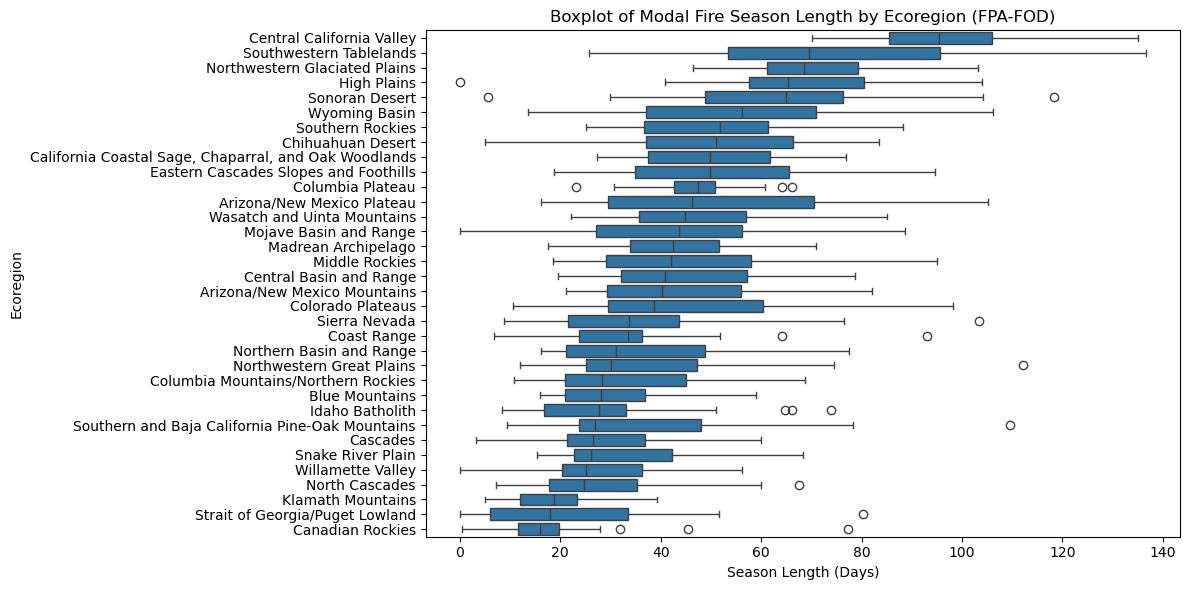

In [128]:
#### Sort
order = fire_stats.groupby('na_l3name')['season_length'].median().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
sns.boxplot(y='na_l3name', x='season_length', data=fire_stats, order=order)  

plt.yticks(rotation=0)

plt.title('Boxplot of Modal Fire Season Length by Ecoregion (FPA-FOD)')
plt.xlabel('Season Length (Days)')
plt.ylabel('Ecoregion')
plt.tight_layout()
plt.show()

In [129]:
ecoregion_stats = fire_stats.groupby('na_l3name').agg(
    med_peak_season=('peak_season', 'median'),
    med_season_length=('season_length', 'median')
).reset_index()
# Display the result
ecoregion_stats.head()

,na_l3name,med_peak_season,med_season_length
0,Arizona/New Mexico Mountains,164.015623,40.154335
1,Arizona/New Mexico Plateau,195.040046,46.286574
2,Blue Mountains,220.454313,28.166049
3,"California Coastal Sage, Chaparral, and Oak Wo...",220.541762,49.906880
4,Canadian Rockies,216.898110,15.928639


In [ ]:
# Save the file out.
out_fp = os.path.join(results_dir, 'ecol3-west_fod_fire-season-length.csv')
fire_season.to_csv(out_fp)
print(f"Saved to {out_fp}.")